# Загружаем всё, что необходимо

In [1]:
!pip install -U onnx onnxruntime apache-tvm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 5.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which

In [2]:
!wget https://github.com/onnx/models/raw/main/vision/classification/resnet/model/resnet50-v1-12.tar.gz

--2023-02-15 18:53:54--  https://github.com/onnx/models/raw/main/vision/classification/resnet/model/resnet50-v1-12.tar.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/main/vision/classification/resnet/model/resnet50-v1-12.tar.gz [following]
--2023-02-15 18:53:55--  https://media.githubusercontent.com/media/onnx/models/main/vision/classification/resnet/model/resnet50-v1-12.tar.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96559469 (92M) [application/octet-stream]
Saving to: ‘resnet50-v1-12.tar.gz’

resnet50-v1-12.tar. 100%[===================>]  92.09M   176MB/

In [3]:
!tar -xzvf "/content/resnet50-v1-12.tar.gz" ""

resnet50-v1-12/
resnet50-v1-12/test_data_set_1/
resnet50-v1-12/test_data_set_1/input_0.pb
resnet50-v1-12/test_data_set_1/output_0.pb
resnet50-v1-12/resnet50-v1-12.onnx
resnet50-v1-12/test_data_set_0/
resnet50-v1-12/test_data_set_0/input_0.pb
resnet50-v1-12/test_data_set_0/output_0.pb
resnet50-v1-12/test_data_set_2/
resnet50-v1-12/test_data_set_2/input_0.pb
resnet50-v1-12/test_data_set_2/output_0.pb


# Импортируем модельку

In [4]:
import tvm
import tvm.relay as relay

import numpy as np
import os
import glob
import onnxruntime as ort

import onnx
from onnx import numpy_helper

Глядим на содержимое

In [5]:
# Load the ONNX model
model = onnx.load("/content/resnet50-v1-12/resnet50-v1-12.onnx")

# Check that the model is well formed
onnx.checker.check_model(model) 

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

graph mxnet_converted_model (
  %data[FLOAT, Nx3x224x224]
) initializers (
  %resnetv17_conv0_weight[FLOAT, 64x3x7x7]
  %resnetv17_batchnorm0_gamma[FLOAT, 64]
  %resnetv17_batchnorm0_beta[FLOAT, 64]
  %resnetv17_batchnorm0_running_mean[FLOAT, 64]
  %resnetv17_batchnorm0_running_var[FLOAT, 64]
  %resnetv17_stage1_conv0_weight[FLOAT, 64x64x1x1]
  %resnetv17_stage1_conv0_bias[FLOAT, 64]
  %resnetv17_stage1_batchnorm0_gamma[FLOAT, 64]
  %resnetv17_stage1_batchnorm0_beta[FLOAT, 64]
  %resnetv17_stage1_batchnorm0_running_mean[FLOAT, 64]
  %resnetv17_stage1_batchnorm0_running_var[FLOAT, 64]
  %resnetv17_stage1_conv1_weight[FLOAT, 64x64x3x3]
  %resnetv17_stage1_batchnorm1_gamma[FLOAT, 64]
  %resnetv17_stage1_batchnorm1_beta[FLOAT, 64]
  %resnetv17_stage1_batchnorm1_running_mean[FLOAT, 64]
  %resnetv17_stage1_batchnorm1_running_var[FLOAT, 64]
  %resnetv17_stage1_conv2_weight[FLOAT, 256x64x1x1]
  %resnetv17_stage1_conv2_bias[FLOAT, 256]
  %resnetv17_stage1_batchnorm2_gamma[FLOAT, 256]
  %resnetv

Запускаем ONNX модель, чисто проверка

In [6]:
test_data_dir = '/content/resnet50-v1-12/test_data_set_0'
model = onnx.load('/content/resnet50-v1-12/resnet50-v1-12.onnx')

# Load inputs
inputs = []
inputs_num = len(glob.glob(os.path.join(test_data_dir, 'input_*.pb')))
for i in range(inputs_num):
    input_file = os.path.join(test_data_dir, 'input_{}.pb'.format(i))
    tensor = onnx.TensorProto()
    with open(input_file, 'rb') as f:
        tensor.ParseFromString(f.read())
    inputs.append(numpy_helper.to_array(tensor))

# Load reference outputs
ref_outputs = []
ref_outputs_num = len(glob.glob(os.path.join(test_data_dir, 'output_*.pb')))
for i in range(ref_outputs_num):
    output_file = os.path.join(test_data_dir, 'output_{}.pb'.format(i))
    tensor = onnx.TensorProto()
    with open(output_file, 'rb') as f:
        tensor.ParseFromString(f.read())
    ref_outputs.append(numpy_helper.to_array(tensor))

# Run the model on the backend
session = ort.InferenceSession(model.SerializeToString(), None)

# get the name of the first input of the model
input_name = session.get_inputs()[0].name  

In [7]:
%%time

outputs = [session.run([], {input_name: inputs[i]})[0] for i in range(ref_outputs_num)][0]

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 135 ms


# Создаём ONNX модель через Apache-TVM

In [8]:
model = onnx.load('/content/resnet50-v1-12/resnet50-v1-12.onnx')

shape_dict = {}
shape_dict["data"] = [1, 3, 224, 224]

mod, params = relay.frontend.from_onnx(model, shape_dict, freeze_params=True)
target = tvm.target.Target("llvm")
dev = tvm.cpu(0)

with tvm.transform.PassContext(opt_level=3):
    tvm_model = relay.build_module.create_executor("graph", mod, dev, target, params).evaluate()

In [9]:
%%time

tvm_outputs = tvm_model(inputs[0])

CPU times: user 550 ms, sys: 45 µs, total: 550 ms
Wall time: 550 ms


Сравниваем результаты (да, это дело должно упасть)

In [10]:
for o, tvm_o in zip(outputs, tvm_outputs.asnumpy()):
    np.testing.assert_almost_equal(o, tvm_o)

AssertionError: ignored

# AutoTVM

С дозволения Егора, используем функции Auto-TVM и AutoScheduler'а для получения результатов.

In [11]:
from tvm.contrib import graph_executor

from tvm import autotvm
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner

def evaluate_performance(lib, data_shape, dtype="float32"):
    # upload parameters to device
    dev = tvm.cpu()
    data_tvm = tvm.nd.array((np.random.uniform(size=data_shape)).astype(dtype))
    module = graph_executor.GraphModule(lib["default"](dev))
    module.set_input(input_name, data_tvm)

    # evaluate
    print("Evaluate inference time cost...")
    print(module.benchmark(dev, number=100, repeat=3))


def extract_tasks_atvm(mod, target, params):
    print("Mod:")
    print(mod)
    print("Extract tasks...")
    tasks = autotvm.task.extract_from_program(
        mod, target=target, params=params
    )
    assert(len(tasks) > 0)
    for idx, task in enumerate(tasks):
        print("Task: %d,  workload: %s" % (idx, task.workload))
    return tasks


def run_tuning_atvm(
    tasks, measure_option, tuner="gridsearch", early_stopping=None, log_filename="tuning.log"
):
    for i, task in enumerate(tasks):
        prefix = "[Task %2d/%2d] " % (i + 1, len(tasks))

        # create tuner
        if tuner == "xgb" or tuner == "xgb-rank":
            tuner_obj = XGBTuner(task, loss_type="rank")
        elif tuner == "ga":
            tuner_obj = GATuner(task, pop_size=50)
        elif tuner == "random":
            tuner_obj = RandomTuner(task)
        elif tuner == "gridsearch":
            tuner_obj = GridSearchTuner(task)
        else:
            raise ValueError("Invalid tuner: " + tuner)

        # do tuning
        n_trial = len(task.config_space)
        tuner_obj.tune(
            n_trial=n_trial,
            early_stopping=early_stopping,
            measure_option=measure_option,
            callbacks=[
                autotvm.callback.progress_bar(n_trial, prefix=prefix),
                autotvm.callback.log_to_file(log_filename),
            ],
        )

In [14]:
log_file = "/content/ONNXResNet50-AutoTVM"

tasks = extract_tasks_atvm(mod, target, params)

measure_option = autotvm.measure_option(
    builder=autotvm.LocalBuilder(),
    runner=autotvm.LocalRunner(repeat=2, enable_cpu_cache_flush=True),
)

run_tuning_atvm(tasks, measure_option, tuner="xgb", early_stopping=10, log_filename=log_file)

Mod:
def @main(%data: Tensor[(1, 3, 224, 224), float32] /* ty=Tensor[(1, 3, 224, 224), float32] */) -> Tensor[(1, 1000), float32] {
  %0 = nn.conv2d(%data, meta[relay.Constant][0] /* ty=Tensor[(64, 3, 7, 7), float32] */, strides=[2, 2], padding=[3, 3, 3, 3], channels=64, kernel_size=[7, 7]) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %1 = nn.batch_norm(%0, meta[relay.Constant][1] /* ty=Tensor[(64), float32] */, meta[relay.Constant][2] /* ty=Tensor[(64), float32] */, meta[relay.Constant][3] /* ty=Tensor[(64), float32] */, meta[relay.Constant][4] /* ty=Tensor[(64), float32] */) /* ty=(Tensor[(1, 64, 112, 112), float32], Tensor[(64), float32], Tensor[(64), float32]) */;
  %2 = %1.0 /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %3 = nn.relu(%2) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %4 = nn.max_pool2d(%3, pool_size=[3, 3], strides=[2, 2], padding=[1, 1, 1, 1]) /* ty=Tensor[(1, 64, 56, 56), float32] */;
  %5 = nn.conv2d(%4, meta[relay.Constant][5] /* ty=Tensor[(64, 64, 1, 1), fl

In [16]:
def evaluate_atvm(module, data_shape, log_file, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext(opt_level=3):
        print("Compile...")
        lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, data_shape)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    with autotvm.apply_history_best(log_file):
        print("Compile...")
        with tvm.transform.PassContext(opt_level=3):
            lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, data_shape)

evaluate_atvm(mod, shape_dict["data"] , log_file, target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  664.2483     654.6063     686.5962     651.5423     15.8518   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  556.0502     556.3335     563.3295     548.4876      6.0625   
               


# Auto-Scheduler

Процесс абсолютно аналогичный, ничего особо интересного

In [17]:
from tvm import auto_scheduler

def extract_tasks(mod, target, params):
    print("Mod:")
    print(mod)
    print("Extract tasks...")
    tasks, task_weights = auto_scheduler.extract_tasks(mod, params, target)
    assert(len(tasks) > 0)

    for idx, task in enumerate(tasks):
        print("Task: %d, desc: %s" % (idx, task.desc))
    return tasks, task_weights

def run_tuning(tasks, task_weights, log_file, n_trials):
    print("Begin tuning...")
    tuner = auto_scheduler.TaskScheduler(tasks, task_weights)
    tune_option = auto_scheduler.TuningOptions(
        num_measure_trials=n_trials,  # change this to 20000 to achieve the best performance
        runner=auto_scheduler.LocalRunner(repeat=10, enable_cpu_cache_flush=True),
        measure_callbacks=[auto_scheduler.RecordToFile(log_file)],
    )

    tuner.tune(tune_option) 

In [18]:
log_file = "/content/ONNXResNet50-Ansor"

tasks, task_weights = extract_tasks(mod, target, params)

run_tuning(tasks, task_weights, log_file,  32)

Mod:
def @main(%data: Tensor[(1, 3, 224, 224), float32] /* ty=Tensor[(1, 3, 224, 224), float32] */) -> Tensor[(1, 1000), float32] {
  %0 = nn.conv2d(%data, meta[relay.Constant][0] /* ty=Tensor[(64, 3, 7, 7), float32] */, strides=[2, 2], padding=[3, 3, 3, 3], channels=64, kernel_size=[7, 7]) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %1 = nn.batch_norm(%0, meta[relay.Constant][1] /* ty=Tensor[(64), float32] */, meta[relay.Constant][2] /* ty=Tensor[(64), float32] */, meta[relay.Constant][3] /* ty=Tensor[(64), float32] */, meta[relay.Constant][4] /* ty=Tensor[(64), float32] */) /* ty=(Tensor[(1, 64, 112, 112), float32], Tensor[(64), float32], Tensor[(64), float32]) */;
  %2 = %1.0 /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %3 = nn.relu(%2) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %4 = nn.max_pool2d(%3, pool_size=[3, 3], strides=[2, 2], padding=[1, 1, 1, 1]) /* ty=Tensor[(1, 64, 56, 56), float32] */;
  %5 = nn.conv2d(%4, meta[relay.Constant][5] /* ty=Tensor[(64, 64, 1, 1), fl

In [19]:
def evaluate(module, data_shape, log_file, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext(opt_level=3):
        print("Compile...")
        lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, data_shape)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    with auto_scheduler.ApplyHistoryBest(log_file):
        print("Compile...")
        with tvm.transform.PassContext(opt_level=3, config={"relay.backend.use_auto_scheduler": True}):
            lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, data_shape)

evaluate(mod, shape_dict["data"], log_file, target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  662.3633     670.5192     672.3515     644.2191     12.8516   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
 1751.8551    1759.1568    1761.5572    1734.8513     12.0634   
               


# Вопросы

1. Очевидно наверное, но по какой причине значения инференсов не сильно 
изменились в случае Ansar, а в случае Auto-TVM стали даже хуже? Любые подозрения подойдут.

2. Насколько сильно число trials влияет на подбор лучших оптимизаций в AutoScheduler? Есть какие-то стандарты? Может хватает 32-64?

3. Можно ли тюнить конкретные слои?
Для этого нужно просто обрабатывать конкретные таски?

4. Auto-TVM имеет баг. По какой-то причине иногда он находит лишь 1 таск вместо 22, кучка экспериментов показала, что это дело будто рандомное. Есть идеи?

# Задание 2

## Создаём ориентир и аналог

Первым делом крафтим сам фильтр Собеля

In [20]:
import tensorflow as tf
from tensorflow import keras

In [21]:
def kernelInitializer(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
          [-1, 0, 1],
          [-2, 0, 2],
          [-1, 0, 1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

x1 = keras.layers.Input((224, 224, 3))
cvl = keras.layers.Conv2D(filters=3, kernel_size=(3, 3), kernel_initializer=kernelInitializer, padding="SAME")

sobel_model = keras.Sequential();
sobel_model.add(x1)
sobel_model.add(cvl)

(3, 3, 3, 3)
tf.Tensor([3 3 1 1], shape=(4,), dtype=int32)
tf.Tensor([3 3 3 3], shape=(4,), dtype=int32)


In [22]:
!wget "https://miro.medium.com/v2/resize:fit:720/0*XmWrGHcgEI9eJh3O" -O "dog.jpg"

--2023-02-15 21:17:34--  https://miro.medium.com/v2/resize:fit:720/0*XmWrGHcgEI9eJh3O
Resolving miro.medium.com (miro.medium.com)... 162.159.152.4, 162.159.153.4, 2606:4700:7::a29f:9804, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.152.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  33.35K  --.-KB/s    in 0.001s  

2023-02-15 21:17:35 (23.6 MB/s) - ‘dog.jpg’ saved [34146/34146]



Загружаем фото для проверки

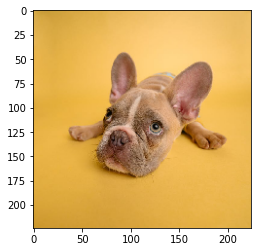

In [23]:
import matplotlib.pyplot as plt 

img_path = "/content/dog.jpg"

img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

plt.imshow(img)
plt.show()

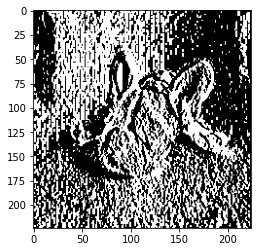

In [24]:
res = sobel_model(keras.preprocessing.image.img_to_array(img).reshape(-1, 224, 224, 3))

plt.imshow(res.numpy().reshape(224, 224, 3))
plt.show()

Наверное верно? Надеемся, что да.

Теперь переводим это дело в формат relay, смотрим на содержимое.

In [25]:
mod, params = relay.frontend.from_keras(sobel_model, {"data": [1, 224, 224, 3]})
mod

#[version = "0.0.5"]
def @main(%input_1, %v_param_1: Tensor[(3, 3, 3, 3), float32], %v_param_2: Tensor[(3), float32]) {
  %0 = nn.conv2d(%input_1, %v_param_1, padding=[1i64, 1i64, 1i64, 1i64], channels=3, kernel_size=[3, 3]);
  nn.bias_add(%0, %v_param_2)
}

Ориентируясь на содержимое, пишем свой аналог.

In [26]:
sobel = relay.var('sobel')
input_tensor_1 = relay.var('x', relay.TensorType((3, 3, 3, 3), "float32"))
input_tensor_2 = relay.var('y', relay.TensorType((3,), "float32"))
v1 = relay.nn.conv2d(sobel,
                     weight=input_tensor_1,
                     padding=[1, 1, 1, 1],
                     channels=3,
                     kernel_size=[3, 3])
v2 = relay.nn.bias_add(v1, input_tensor_2)
f = relay.Function([sobel, input_tensor_1, input_tensor_2], v2)
f

fn (%sobel, %x: Tensor[(3, 3, 3, 3), float32], %y: Tensor[(3), float32]) {
  %0 = nn.conv2d(%sobel, %x, padding=[1, 1, 1, 1], channels=3, kernel_size=[3, 3]);
  nn.bias_add(%0, %y)
}

# Прогоняем через тюнинг

 Возник баг из телеги (что-то про обращение к логам). Воспользуемся решением из телеги, соответственно, а именно - переведём нашу модельку из tf.keras в onnx. Там уж точно ничего плохого случится не должно, да ведь?

 Для этим воспользуемся либой tf2onnx.

In [27]:
!pip install tf2onnx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 8.3 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [28]:
import tf2onnx

onnx_sobel_model, _ = tf2onnx.convert.from_keras(sobel_model, [tf.TensorSpec([1, 224, 224, 3], tf.float32, name='data')])
mod, params = relay.frontend.from_onnx(onnx_sobel_model, {"data": [1, 224, 224, 3]})

with tvm.transform.PassContext(opt_level=3):
    tvm_model = relay.build_module.create_executor("graph", mod, dev, target, params).evaluate()

## Auto-TVM

In [29]:
log_file = "/content/Sobel-AutoTVM"

tasks = extract_tasks_atvm(mod, target, params)

measure_option = autotvm.measure_option(
    builder=autotvm.LocalBuilder(),
    runner=autotvm.LocalRunner(repeat=10, enable_cpu_cache_flush=True),
)

run_tuning_atvm(tasks, measure_option, tuner="xgb", log_filename=log_file)

evaluate_atvm(mod,  [1, 224, 224, 3], log_file, target)

Mod:
def @main(%data: Tensor[(1, 224, 224, 3), float32] /* ty=Tensor[(1, 224, 224, 3), float32] */) -> Tensor[(1, 224, 224, 3), float32] {
  %0 = transpose(%data, axes=[0, 3, 1, 2]) /* ty=Tensor[(1, 3, 224, 224), float32] */;
  %1 = nn.conv2d(%0, meta[relay.Constant][0] /* ty=Tensor[(3, 3, 3, 3), float32] */, padding=[1, 1, 1, 1], channels=3, kernel_size=[3, 3]) /* ty=Tensor[(1, 3, 224, 224), float32] */;
  transpose(%1, axes=[0, 2, 3, 1]) /* ty=Tensor[(1, 224, 224, 3), float32] */
}


Extract tasks...
Task: 0,  workload: ('conv2d_NCHWc.x86', ('TENSOR', (1, 3, 224, 224), 'float32'), ('TENSOR', (3, 3, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32')
[Task  1/ 1]  Current/Best:    2.31/  12.00 GFLOPS | Progress: (88/88) | 105.06 s Done.
Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
   2.6753       2.4931  

## Auto-Scheduler

In [ ]:
log_file = "/content/Sobel-Ansor"

tasks, task_weights = extract_tasks(mod, target, params)

run_tuning(tasks, task_weights, log_file,  32)

evaluate(mod, [1, 224, 224, 3], log_file, target)

Mod:
def @main(%data: Tensor[(1, 224, 224, 3), float32] /* ty=Tensor[(1, 224, 224, 3), float32] */) -> Tensor[(1, 224, 224, 3), float32] {
  %0 = transpose(%data, axes=[0, 3, 1, 2]) /* ty=Tensor[(1, 3, 224, 224), float32] */;
  %1 = nn.conv2d(%0, meta[relay.Constant][0] /* ty=Tensor[(3, 3, 3, 3), float32] */, padding=[1, 1, 1, 1], channels=3, kernel_size=[3, 3]) /* ty=Tensor[(1, 3, 224, 224), float32] */;
  transpose(%1, axes=[0, 2, 3, 1]) /* ty=Tensor[(1, 224, 224, 3), float32] */
}


Extract tasks...
Task: 0, desc: vm_mod_fused_nn_contrib_conv2d_NCHWc
Begin tuning...
|  ID  |                       Task Description                        | Latency (ms) | Speed (GFLOPS) | Trials |
-----------------------------------------------------------------------------------------------------------------
|    0 |                          vm_mod_fused_nn_contrib_conv2d_NCHWc |            - |              - |      0 |
----------------------------------------------------------------------------------